# Optimization of spatial infraestructure for EV charging

## II. Problem formulation
$$ min \sum_{i,j} c_{ij} \pi_{ij} $$

Subject to:

$$ \sum_{j} \pi_{ij} = q_{i} $$
$$ \sum_{i} \pi_{ij} = s_{i}$$

Typical cost function:
$$C = (c_{ij})$$
Where c is a convex function, i.e.: the distance between station location and demand location in some norm:
$$c_{ij} = c(x_{i}, y_{j}) = |x_{i} - y_{j}|$$

In [208]:
import Pkg;
Pkg.add("Mosek")

   Resolving package versions...
  No Changes to `C:\Users\Emiliano\Documents\transport_problems\Project.toml`
  No Changes to `C:\Users\Emiliano\Documents\transport_problems\Manifest.toml`


In [203]:
import Pkg; Pkg.add("MosekTools")

   Resolving package versions...
  No Changes to `C:\Users\Emiliano\Documents\transport_problems\Project.toml`
  No Changes to `C:\Users\Emiliano\Documents\transport_problems\Manifest.toml`


General declarations and functions:

In [206]:
using JuMP, GLPK, Mosek
using VoronoiCells, GeometryBasics, Plots
using Random
using Statistics

┌ Info: Precompiling MosekTools [1ec41992-ff65-5c91-ac43-2df89e9693a4]
└ @ Base loading.jl:1342
ERROR: LoadError: InitError: could not load library "C:\Users\Emiliano\.julia\packages\Mosek\au3Cq\deps\src\mosek\9.3\tools\platform\win64x86\bin\mosek64_9_3.dll"
The specified module could not be found. 
Stacktrace:
  [1] makeenv
    @ C:\Users\Emiliano\.julia\packages\Mosek\au3Cq\src\Mosek.jl:30 [inlined]
  [2] __init__()
    @ Mosek C:\Users\Emiliano\.julia\packages\Mosek\au3Cq\src\Mosek.jl:173
  [3] _include_from_serialized(path::String, depmods::Vector{Any})
    @ Base .\loading.jl:696
  [4] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String)
    @ Base .\loading.jl:782
  [5] _require(pkg::Base.PkgId)
    @ Base .\loading.jl:1020
  [6] require(uuidkey::Base.PkgId)
    @ Base .\loading.jl:936
  [7] require(into::Module, mod::Symbol)
    @ Base .\loading.jl:923
  [8] include
    @ .\Base.jl:384 [inlined]
  [9] include_package_for_output(pkg::Base.PkgId, input::String, dep

LoadError: Failed to precompile MosekTools [1ec41992-ff65-5c91-ac43-2df89e9693a4] to C:\Users\Emiliano\.julia\compiled\v1.6\MosekTools\jl_84DF.tmp.

In [209]:
using MosekTools

┌ Info: Precompiling MosekTools [1ec41992-ff65-5c91-ac43-2df89e9693a4]
└ @ Base loading.jl:1342
ERROR: LoadError: InitError: could not load library "C:\Users\Emiliano\.julia\packages\Mosek\au3Cq\deps\src\mosek\9.3\tools\platform\win64x86\bin\mosek64_9_3.dll"
The specified module could not be found. 
Stacktrace:
  [1] makeenv
    @ C:\Users\Emiliano\.julia\packages\Mosek\au3Cq\src\Mosek.jl:30 [inlined]
  [2] __init__()
    @ Mosek C:\Users\Emiliano\.julia\packages\Mosek\au3Cq\src\Mosek.jl:173
  [3] _include_from_serialized(path::String, depmods::Vector{Any})
    @ Base .\loading.jl:696
  [4] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String)
    @ Base .\loading.jl:782
  [5] _require(pkg::Base.PkgId)
    @ Base .\loading.jl:1020
  [6] require(uuidkey::Base.PkgId)
    @ Base .\loading.jl:936
  [7] require(into::Module, mod::Symbol)
    @ Base .\loading.jl:923
  [8] include
    @ .\Base.jl:384 [inlined]
  [9] include_package_for_output(pkg::Base.PkgId, input::String, dep

LoadError: Failed to precompile MosekTools [1ec41992-ff65-5c91-ac43-2df89e9693a4] to C:\Users\Emiliano\.julia\compiled\v1.6\MosekTools\jl_1F7B.tmp.

In [132]:
function get_cost_matrix(x, y, norm=2)    
    m = size(x)[1]
    n = size(y)[1]
    #Calculo los costos Cij = |xi-yj| (distancia euclidea en R^2)
    c1 = (x[:,1]*ones(1,n) - ones(m,1)*y[:,1]').^norm
    c2 = (x[:,2]*ones(1,n) - ones(m,1)*y[:,2]').^norm
    return (c1+c2).^(1/norm)
end

get_cost_matrix (generic function with 2 methods)

In [147]:
function plot_assignments(x, y, s, pi, k = 0, voronoi = true)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]
    #k = (k == 0) ? k = n : k

    # Create Stations List
    points = [Point2(y[i,1], y[i,2]) for i in 1:n] 

    # Voronoi Cells
    rect = Rectangle(Point2(0, 0), Point2(1, 1))
    tess = voronoicells(points, rect);

    #Assigments
    assigned_index = [argmax(pi[i,:]) for i in 1:m];
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    scatter(X, Y, aspect_ratio=:equal, markersize = 3, legend = :outertopright ) # Plot EVs (differente color by each Station)
    scatter!(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
    if voronoi 
        plot!(tess, color = :black)
    end
end

plot_assignments (generic function with 3 methods)

In [134]:
m = 100; # Demand locations count
n = 10; # Station locations count
norm = 2; # Manhattan Metric

In [135]:
x = sortslices(rand(m,2), dims = 1);
y = sortslices(rand(n,2), dims = 1);
C = get_cost_matrix(x, y, norm); #Matriz de costos
q = ones(m,1);

## III. Fixed Locations
We assume that the station locations $\{ y_j \}$ have already been selected

### A. Fixed Capacities

#### Simple discrete counterexample
$$C = \begin{bmatrix}
1 & 3\\
3 & 1
\end{bmatrix}$$

$$q = \begin{bmatrix}
1\\
2
\end{bmatrix}$$

$$s = \begin{bmatrix}
2 & 1
\end{bmatrix}$$

Then:

$$\Pi^{*} = \begin{bmatrix}
1 & 0\\
1 & 1
\end{bmatrix}$$

In [136]:
C1 = [1 3; 3 1]
q1 = [1; 2]
s = [2 1]


model = JuMP.Model(GLPK.Optimizer)

@variable(model,pi[1:2, 1:2] >=0 )
@constraint(model, sum(pi, dims=2) .== q1)
@constraint(model, sum(pi, dims=1) .== s )

@objective(model,Min, sum( C1.*pi ))

#print(model)
model

optimize!(model)
value.(pi)

2×2 Matrix{Float64}:
 1.0  0.0
 1.0  1.0

#### Proposition 1

Suppose:

* Más ubicaciones de demanda, que estaciones: $m \ge n$
* Demandas unitarias: $q_{i} = 1$, $i = 1, ..., m$
* Capacidad justa: $s_{j} \in Z, s_{j} > 0, \sum_{j} s_{j} = m$

Then: 

La solución óptima $\Pi^{*}$ debe ser de ceros y unos ($\pi_{ij} \in \{ 0, 1\}$)


In [137]:
#Vector de capacidades
aux = rand(n,1); #random proportion for s
s = round.(aux/sum(aux)*m); #normalization
s[argmax(s)] += (m - sum(s)); #error correction
#s

In [138]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,pi[1:m,1:n]>=0)

@constraint(model, sum(pi, dims=2) .== q)
@constraint(model, sum(pi, dims=1) .== s' )

@objective(model,Min, sum( C.*pi ))

#print(model)
model;

In [139]:
optimize!(model)
value.(pi);
value.(s)

10×1 Matrix{Float64}:
  8.0
 18.0
 13.0
  7.0
  6.0
  6.0
  5.0
  8.0
 19.0
 10.0

In [39]:
#[TODO] Find values not in 0 or 1 to verify
find(value.(pi) != 0 || value.(pi) != 1);

LoadError: UndefVarError: find not defined

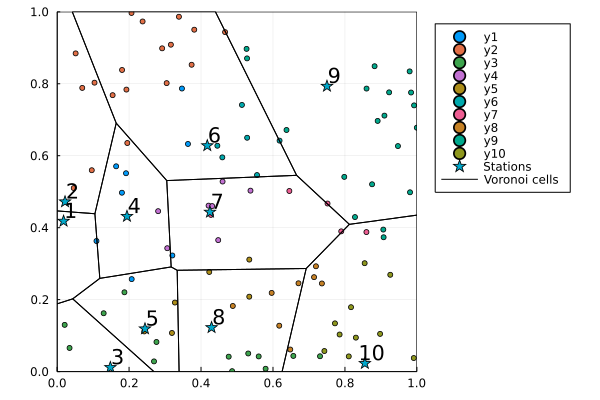

In [148]:
# Graficar la asignacion
pi = value.(pi) 
plot_assignments(x, y, s, pi)

#### Case m = n

In [111]:
m2 = 10; # Demand locations count
n2 = 10; # Station locations count

x2 = sortslices(rand(m2,2), dims = 1);
y2 = sortslices(rand(n2,2), dims = 1);
C2 = get_cost_matrix(x2, y2, norm); #Matriz de costos
q2 = ones(m2,1);

#Vector de capacidades
s2 = ones(n2,1); 

In [112]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,pi[1:m2,1:n2]>=0)

@constraint(model, sum(pi, dims=2) .== q2)
@constraint(model, sum(pi, dims=1) .== s2' )

@objective(model,Min, sum( C2.*pi ))

#print(model)
model;

In [117]:
optimize!(model)
value.(pi);

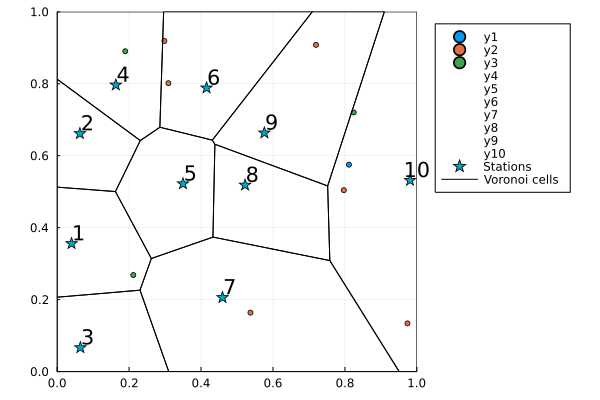

In [154]:
# Graficar la asignacion
pi = value.(pi) 
plot_assignments(x2, y2, s2, pi)

[TODO] ¿Verificar lo de extender una $m \times n$ a $m \times m$, ponderar la capacidad y que de como el $m = n$, para luego sumar las columnas de $\Pi^{*}$ y recuperar la original ?

### B. Free Capacities

We assume that the station locations $\{ y_j \}$ have already been selected, and their supply capacities can be arbitrarly chosen.

In [155]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,pi[1:m,1:n]>=0)

@constraint(model, sum(pi, dims=2) .== q)

@objective(model,Min, sum( C.*pi ))

#print(model)
model;

In [156]:
optimize!(model)

In [45]:
#Vector de capacidades
s = sum(value.(pi), dims=1)'

10×1 adjoint(::Matrix{Float64}) with eltype Float64:
 17.0
  3.0
  9.0
  4.0
 16.0
 10.0
  8.0
 11.0
 10.0
 12.0

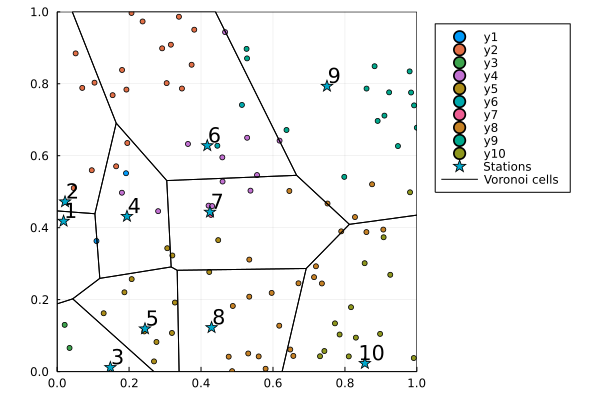

In [163]:
# Graficar la asignacion
pi = value.(pi) 
plot_assignments(x, y, s, pi)

### C. Constrained or penalized capacities

We assume that the station locations $\{ y_j \}$ have already been selected, and their supply capacities can be arbitrarly chosen.

[TODO] ¿Network graph?

#### Proposition 2

Suppose:

* Más ubicaciones de demanda, que estaciones: $m \ge n$
* Demandas unitarias: $q_{i} = 1$, $i = 1, ..., m$
* Capacidades topeadas (aseguran demanda): $\overline{s}_{j} \in Z, s_{j} > 0, \sum_{j} \overline{s}_{j} \ge m$

Then: 

La solución óptima $\Pi^{*}$ debe ser de ceros y unos ($\pi_{ij} \in \{ 0, 1\}$)


In [165]:
#Vector de cotas de capacidad
aux = rand(n,1); #random proportion for s
tolerance = 0.2; 
s_max = round.(aux/sum(aux)*m*(1+tolerance)) #normalization

10×1 Matrix{Float64}:
  0.0
 12.0
  6.0
 10.0
  6.0
 20.0
 17.0
 21.0
 13.0
 14.0

In [166]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,pi[1:m,1:n]>=0)

@constraint(model, sum(pi, dims=2) .== q)
@constraint(model, sum(pi, dims=1) .<= s_max' )

@objective(model,Min, sum( C.*pi ))

#print(model)
model;

In [168]:
optimize!(model)

In [169]:
value.(pi)

100×10 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0

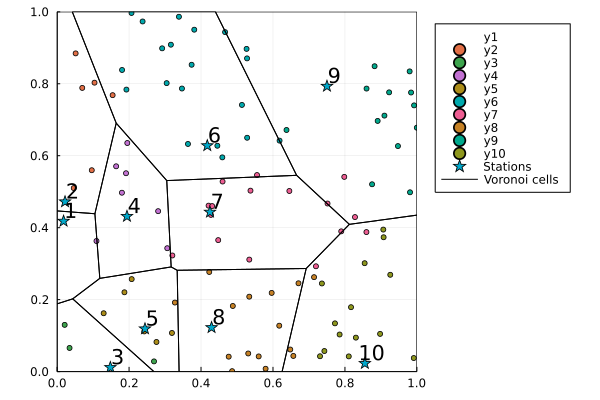

In [170]:
# Graficar la asignacion
pi = value.(pi) 
plot_assignments(x, y, s, pi)

#### Penalized capacities

Suppose, instead, that one is designing an installation with known locations but still has not defined the relevant capacities. Leaving them complete free may be undesirable, but one could seek to even out the allocation somewhat between locations.

With this aim, we consider a problem where a soft penalty term to the transport cost:

$$ min \sum_{ij} c_{ij} \pi_{ij} + \epsilon \sum_{j} \phi_{j}(s_{j})$$

Subject to:

$$\sum_{j} \pi_{ij} = q_{i}$$
$$\sum_{i} \pi_{ij} = s_{j}$$

In this case, we use $\phi_{j}(s) = \frac{1}{2}s^{2}$

In [171]:
function phi(s)
    return 0.5*(s.^2)
end

phi (generic function with 1 method)

In [187]:
using Ipopt
epsilon = 0

model = JuMP.Model(Ipopt.Optimizer)

@variable(model, pi[1:m,1:n]>=0)
@variable(model, s[1:n]>=0)

@constraint(model, sum(pi, dims=2) .== q)
@constraint(model, sum(pi, dims=1) .== s')

@objective(model,Min, sum( C.*pi ) + epsilon*sum(phi(s)));


In [188]:
optimize!(model)
value.(pi), objective_value(model)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2010
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1010
                     variables with only lower bounds:     1010
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.3457291e+00 9.90e-01 7.02e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

([1.2031322231045985e-8 5.018328190523489e-9 … -6.9065696701177236e-9 -6.23548338563685e-9; 1.0789993510574924e-9 -1.0219501669365071e-9 … -7.192898395221316e-9 -6.390560196727756e-9; … ; -6.777411364533748e-9 -6.691407834609658e-9 … 1.0000000496328996 -4.788368117799083e-9; -6.6139771427634376e-9 -6.5339001503614825e-9 … 1.0000000452582198 -3.6475720296982886e-9], 18.97335559866778)

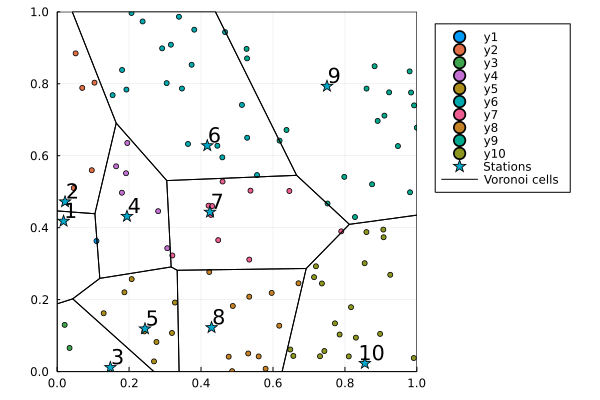

In [189]:
# Graficar la asignacion
pi = value.(pi) 
plot_assignments(x, y, s, pi)

## IV. Location Selection
In this section we consider the situation where the location poitns are also part of the design.

### A. Free locations

[TODO] K - Means

### B. Sparse selection over a set of candidate locations

Example 1 - Verification

$$x = y = \begin{bmatrix}
1\\
2\\
5
\end{bmatrix}$$

Then:

$$C = \begin{bmatrix}
0 & 1 & 4\\
1 & 0 & 3\\
4 & 3 & 0
\end{bmatrix}$$

$$q = \begin{bmatrix}
2\\
3\\
1
\end{bmatrix}$$

$$\overline{s} = \begin{bmatrix}
s & s & s
\end{bmatrix}$$

Case 1: s = 5

In [196]:
model = JuMP.Model(GLPK.Optimizer)

@variable(model,pi[1:m,1:n]>=0)

@constraint(model, sum(pi, dims=2) .== q)
@constraint(model, sum(pi, dims=1) .<= s_max' )

@objective(model,Min, sum( C.*pi ));

In [197]:
optimize!(model)
value.(pi), objective_value(model);

Case 2: s = 4

### MILP (Mixed-integer linear programming)

$$min \sum_{ij} c_{ij} \pi_{ij}$$

Subject to:

$$\sum_{j} \pi_{ij} = q_i$$
$$\sum_{i} \pi_{ij} \le b_{j}\overline{s}_{j}$$
$$\sum_{j} b_{j} \le k$$
$$b_{j} \in \{ 0, 1\}$$

Where: 

$b_{j}$ indicates whether station $y_{j}$ is active or not

$k$ is the count of active actions

In [220]:
k = 4
q = 1*ones(m,1)
s_max = 100*ones(n,1);
# Validar que la cantidad de prendidos, con la capacidad q, den para cubrir todos los EVs

In [221]:
#model = JuMP.Model(Mosek.Optimizer)
model = JuMP.Model(GLPK.Optimizer)

@variable(model,pi[1:m,1:n]>=0)
@variable(model, b[1:n], Bin)

@constraint(model, sum(pi, dims=2).== q)
@constraint(model, sum(pi, dims=1)' .<= (b.*s_max) )
@constraint(model, sum(b) <= k)

@objective(model,Min, sum( C.*pi ));

In [222]:
optimize!(model)
objective_value(model)

22.88309178303655

In [223]:
value.(pi)

100×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [224]:
value.(b)

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 1.0
 1.0
 1.0

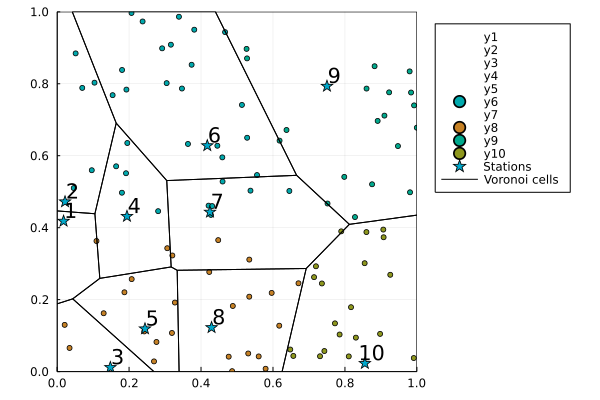

In [225]:
# Graficar la asignacion
pi = value.(pi) 
plot_assignments(x, y, s, pi)